# BERT Fine-Tuning チュートリアル
## 参考⇒https://mccormickml.com/2019/07/22/BERT-fine-tuning/

*Revised on 12/13/19 to use the new [transformers](https://github.com/huggingface/transformers) interface.*
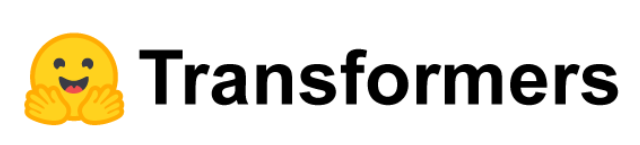




日本語版のモデル・関数が2019年１２月リリース
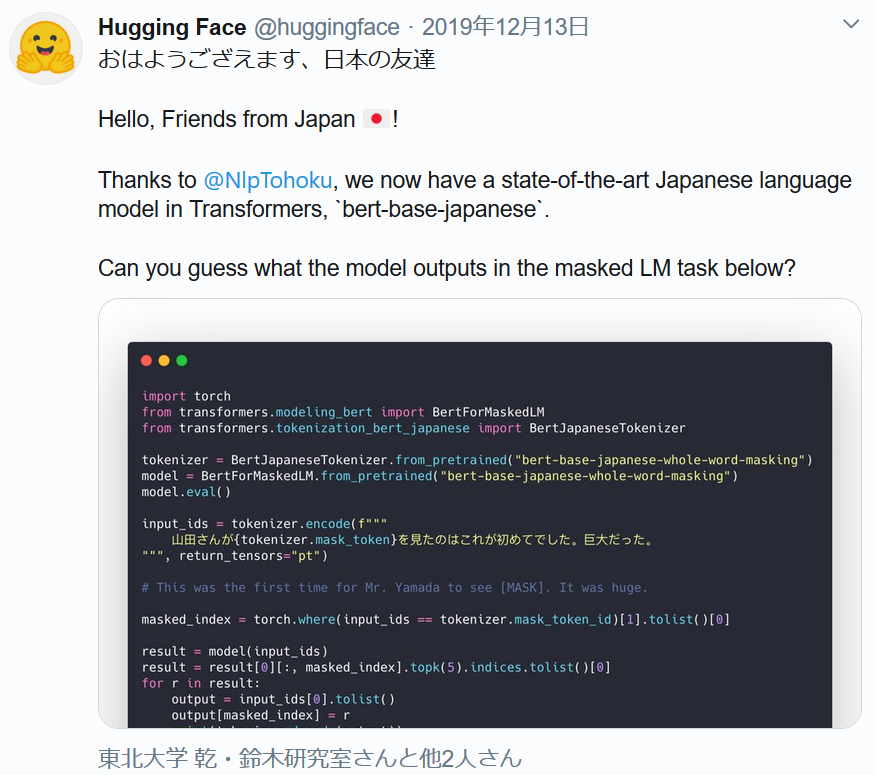

実際に手を動かして、BERTの仕組みを理解する。  
[世界で一番分かり易いBERTの紹介動画](https://youtu.be/x66kkDnbzi4)  
[日本で一番分かり易いTransformerの紹介動画](https://www.youtube.com/watch?v=g5DSLeJozdw&t=564s)




# Fine-Tuningとは？

独自のデータとpre-trainedのバートモデルを組み合わせて、特定のタスク（分類、エンティティ認識、質問応答など）に特化したモデルを作る技法。即ち、FInr-Tuningとは、転移学習のこと。

基本的には、Transformerが作成したモデル(pre-trained)・関数を使う。自分たちは、出力層を付け加えて学習させるだけ(fine-tuning)。 

BERTを使用してテキスト分類器を作る。分類は、2値分類とする
事前に訓練されたBERTモデルを使用し、そのモデルの最後に訓練されていない出力層を追加。訓練データにより、出力層の重みを求める。
    
以降、確認します！

# プログラムを見ていきます

## 初めの設定

Huging Faceのライブラリは、BERTを操作するための最も広く受け入れられている強力なpytorchインターフェイス。ライブラリには、さまざまな事前トレーニング済みトランスモデルがサポートされている。また、特定のタスクに適したこれらのモデルのビルド済みの修正も含まれている（日本語版のビルド済モデルもある）。今回、同モデルに加えて、BertForSequenceClassificationメソッドを使用する。

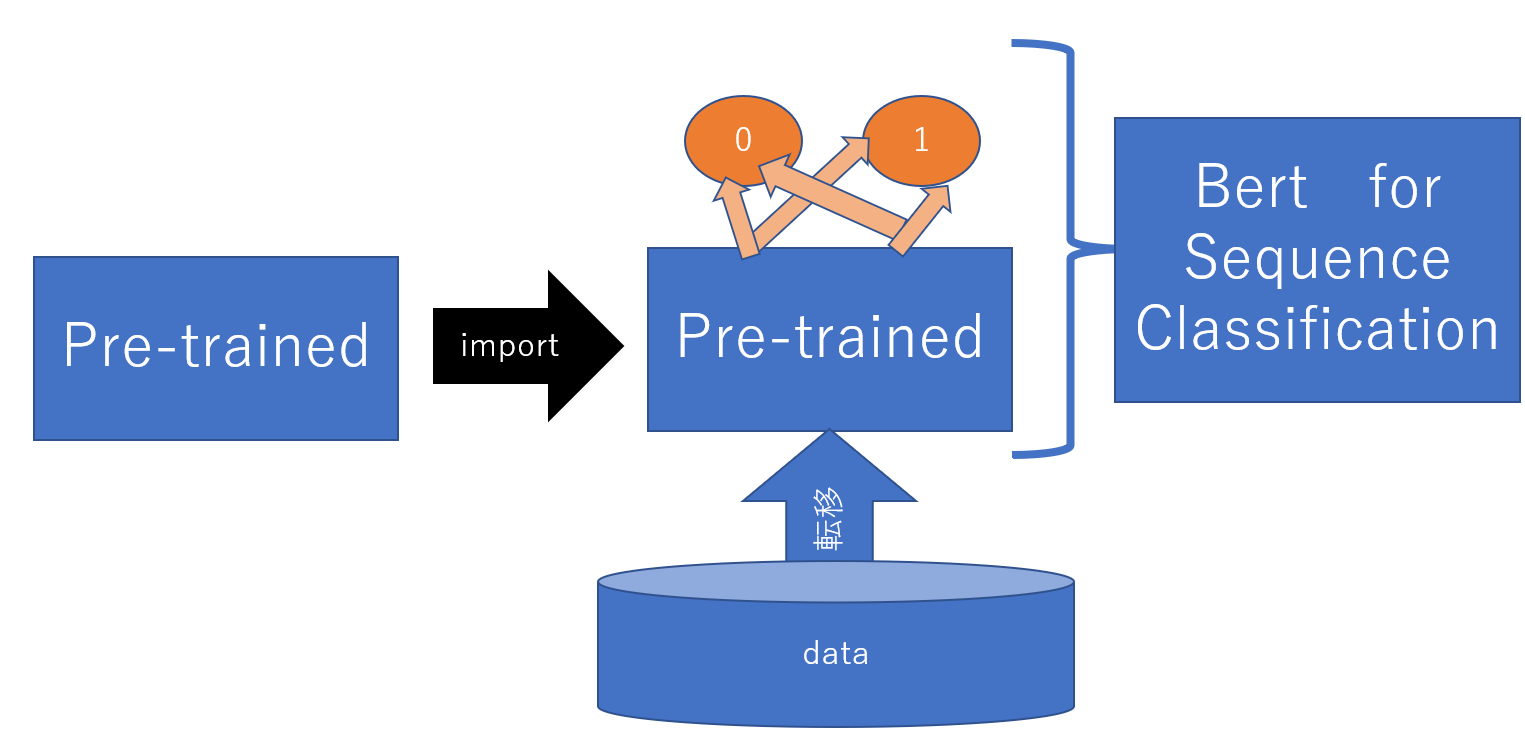

In [3]:
#HuggingFaceのtransformersを使わせていただきます。
!pip install transformers

  Created wheel for sacremoses: filename=sacremoses-0.0.38-cp37-none-any.whl size=884633 sha256=e71da55f4d42c2fa18dbbf454a5b7613a9f561bf06c800fd8d63289cae236ca2
  Stored in directory: C:\Users\araik\AppData\Local\pip\Cache\wheels\6d\ec\1a\21b8912e35e02741306f35f66c785f3afe94de754a0eaf1422
Successfully built sacremoses


You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [4]:
#GPU環境の構築
#[左上の編集タブ 🡒 ノートブックの設定 🡒 ハードウェアアクセラレータ 🡒 (NONEから、GPUへ！)]
#★★GPUが使えない場合、CPUに自動で切り替えるので問題無！！★★

import tensorflow as tf

# GPUのデバイス名を追加する。.
device_name = tf.test.gpu_device_name()

# GPUのデバイス名を表示する。:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

C:\Users\araik\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\araik\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\araik\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\araik\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:529: FutureWarning: Passi

SystemError: GPU device not found

In [5]:
import torch

# CUDA（Compute Unified Device Architecture：クーダ）とは、NVIDIAが開発・提供している、
#GPU向けの汎用並列コンピューティングプラットフォーム（並列コンピューティングアーキテクチャ）およびプログラミングモデル
#GPUが使えるかどうか確認する。
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

No GPU available, using the CPU instead.


## テキストデータを採ってくる

In [117]:
import pandas as pd

# データセットのロード.
df = pd.read_excel("gan_sinkin.xlsx",encoding="utf-8")
#データをシャッフル！
df_s = df.sample(frac=1)

print('Number of training sentences: {:,}\n'.format(df_s.shape[0]))

##★★★★★★★★★★★★★★★★★★★★
#処理が重すぎるので軽量化！（GPU使えるなら、ここ要らない。）
df_s = df_s[:50]

Number of training sentences: 486



In [118]:
df_s.loc[df_s.label == 1].sample(5)[['sentence', 'label']]

,sentence,label
348,腎血管性高血圧症 ・・・ 19％,1
405,疫学的な推計によると、喫煙者は心筋梗塞により死亡する危険性が非喫煙者に比べて約1.7倍高くな...,1
456,一刻を争うときに裸見られるのが嫌だと言ってそれが元で半身不随になりたきゃどうぞ。,1
471,罪悪感を煽る。,1
467,#BoxFresh https://t.co/4aPxoWrZRl,1


In [119]:
# 文とラベルに分離する。
sentences = df_s.sentence.values
labels = df_s.label.values

In [120]:
labels

array([0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 0], dtype=int64)

In [28]:
#huggingfaceさんが、日本語学習済みのモデルを作って下さいました！
#mecabもいるんでダウンロードしてください！！
#https://qiita.com/hina2211/items/06bf360479b6cfbb5ac6  ---windowsでもすぐにMecabが使える。
#(windows:64の野良ビルドを実行すればすぐ。)
#!pip install mecab-python-windows
from transformers import BertJapaneseTokenizer

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertJapaneseTokenizer.from_pretrained('bert-base-japanese-whole-word-masking')

Loading BERT tokenizer...


I0218 22:21:27.885300 13012 tokenization_utils.py:418] loading file https://s3.amazonaws.com/models.huggingface.co/bert/cl-tohoku/bert-base-japanese-whole-word-masking-vocab.txt from cache at C:\Users\araik\.cache\torch\transformers\ae4d597c0697c617ab6c6c913effc265b7e606830a3b373dfcaeca1794ab9229.5fac9da4d8565963664ed9744688dc7008ff5ec4045f604e9515896f9fe46d9c


In [54]:
# 文章を出してみる
print(' Original: ', sentences[1])

# 形態素解析.
print('Tokenized: ', tokenizer.tokenize(sentences[1]))

# 単語⇒id。実際の処理はid。ちなみに、[CLS]=102,[SEP]=103
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[1])))

 Original:  祖父のお葬式の日には20年前に亡くなった祖母の遺影を持ってきて並べて置いた。祖父はある夜突然逝ってしまった。いつも通りの祖父だった。
Tokenized:  ['祖父', 'の', 'お', '葬', '##式', 'の', '日', 'に', 'は', '20', '年', '前', 'に', '亡くなっ', 'た', '祖母', 'の', '遺', '##影', 'を', '持っ', 'て', 'き', 'て', '並べ', '##て', '置い', 'た', '。', '祖父', 'は', 'ある', '夜', '突然', '逝', '##っ', 'て', 'しまっ', 'た', '。', 'いつも', '通り', 'の', '祖父', 'だっ', 'た', '。']
Token IDs:  [5235, 5, 73, 4891, 28707, 5, 32, 7, 9, 41, 19, 174, 7, 5741, 10, 11960, 5, 914, 29016, 11, 1330, 16, 322, 16, 8228, 28456, 4050, 10, 8, 5235, 9, 31, 1563, 6258, 13878, 28468, 16, 1820, 10, 8, 9749, 939, 5, 5235, 308, 10, 8]


In [121]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []

# For every sentence...
for sent in sentences:
    # `encode` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    encoded_sent = tokenizer.encode(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'

                        # This function also supports truncation and conversion
                        # to pytorch tensors, but we need to do padding, so we
                        # can't use these features :( .
                        #max_length = 128,          # Truncate all sentences.
                        #return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.
    input_ids.append(encoded_sent)

# Print sentence 0, now as a list of IDs.
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])
print('Token IDs:', input_ids[1])
print('Token IDs:', input_ids[2])
print('Token IDs:', input_ids[3])

Original:  相変わらず馬鹿だね龍子www医療に対して全く無知。だから市立病院で蛮行の限りを尽くして来た訳だが。転移無双の癌は施し様がない。抗癌剤と放射線治療が何処まで延命に繋がるか程度。転移性脊髄腫瘍は極度の悪質。原発巣の前立腺癌切除も意味ないし脊髄腫瘍切除も意味ない。 https://t.co/AHnizFMrBM
Token IDs: [2, 423, 28801, 1747, 28700, 19546, 75, 1852, 2423, 28601, 21749, 2646, 769, 3125, 348, 28798, 8, 17957, 1928, 2030, 12, 22562, 28529, 5, 2811, 11, 13128, 16, 1276, 10, 3218, 75, 14, 8, 14561, 25112, 5, 8683, 9, 8990, 741, 14, 80, 8, 2096, 30436, 29819, 13, 10474, 3068, 14, 1037, 29285, 126, 1304, 28911, 7, 13063, 29, 1730, 8, 14561, 245, 18726, 12743, 9, 21073, 5, 27976, 8, 13240, 7254, 5, 174, 28607, 30681, 8683, 25411, 28, 967, 6415, 18726, 12743, 25411, 28, 967, 80, 8, 21313, 28589, 16831, 822, 143, 20852, 465, 192, 28805, 28550, 6472, 28718, 28654, 28548, 24264, 3]
Token IDs: [2, 4931, 14239, 29296, 28718, 23830, 28695, 21313, 28589, 16831, 822, 143, 20852, 465, 57, 2187, 28682, 29296, 28538, 28865, 28548, 29491, 28680, 28595, 3]
Token IDs: [2, 9680, 27345, 9594, 14084, 245, 27345, 23, 171, 14, 1113, 707, 22

In [122]:
len(input_ids)

50

In [123]:
print('Max sentence length: ', max([len(sen) for sen in input_ids]))

Max sentence length:  104


In [124]:
# PADシークエンスを入れる。PAD=文字数を統一するための穴埋め。
from keras.preprocessing.sequence import pad_sequences

# レングスの指定をする。
MAX_LEN = 120

print('\nPadding/truncating all sentences to %d values...' % MAX_LEN)

print('\nPadding token: "{:}", ID: {:}'.format(tokenizer.pad_token, tokenizer.pad_token_id))

# Pad our input tokens with value 0.
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", 
                          value=0, truncating="post", padding="post")

print('\nDone.')


Padding/truncating all sentences to 120 values...

Padding token: "[PAD]", ID: 0

Done.


In [125]:
input_ids[0]

array([    2,   423, 28801,  1747, 28700, 19546,    75,  1852,  2423,
       28601, 21749,  2646,   769,  3125,   348, 28798,     8, 17957,
        1928,  2030,    12, 22562, 28529,     5,  2811,    11, 13128,
          16,  1276,    10,  3218,    75,    14,     8, 14561, 25112,
           5,  8683,     9,  8990,   741,    14,    80,     8,  2096,
       30436, 29819,    13, 10474,  3068,    14,  1037, 29285,   126,
        1304, 28911,     7, 13063,    29,  1730,     8, 14561,   245,
       18726, 12743,     9, 21073,     5, 27976,     8, 13240,  7254,
           5,   174, 28607, 30681,  8683, 25411,    28,   967,  6415,
       18726, 12743, 25411,    28,   967,    80,     8, 21313, 28589,
       16831,   822,   143, 20852,   465,   192, 28805, 28550,  6472,
       28718, 28654, 28548, 24264,     3,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0])

In [126]:
# attentionのマスクを作る！！
attention_masks = []

# 全部の文に対して...
for sent in input_ids:
    
    # Create the attention mask.
    # tokenid = 0⇒0.つまり、PADを０にしている。
    # tokenid > 0⇒1.つまり、PADでなければ１にしている。
    #要するに、文字があれば１．無い（PAD）であれば０
    att_mask = [int(token_id > 0) for token_id in sent]
    
    # アテンションマスクの蓄積。
    attention_masks.append(att_mask)

#アテンションマスクの出力例。
#[1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
#[1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]

In [127]:
# トレインデータと、テストデータにスプリット
from sklearn.model_selection import train_test_split

train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
                                                            random_state=2018, test_size=0.1)
#アテンションマスクも同様に分割。
train_masks, validation_masks, _, _ = train_test_split(attention_masks, labels,
                                             random_state=2018, test_size=0.1)

In [128]:
train_inputs[0]

array([    2,  9680, 27345,  9594, 14084,   245, 27345,    23,   171,
          14,  1113,   707,   222,  9136, 28584, 29273,  4198,   523,
           6,  9801, 29977,   617,     1,  2048,     6, 16039,  1492,
       28477,  2048,     6,  2552,  9926,  9784,  2048,     6, 15921,
        9432,     6, 10605,   732,   224, 28922,     6,  8683,     5,
       14561,     6, 10397,   245, 19015, 30383,     6,   237, 31684,
         245, 16039,  3695,     6,     1, 11776,  3695,     6, 12878,
           1,     6, 27196, 20241,     6,  6704, 28551, 27196, 25745,
           6, 11776, 26505,     3,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0])

In [129]:
train_labels

array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1,
       1], dtype=int64)

In [130]:
# パイトーチ用に、テンソルに変換する。
#リストにtensorの文字が付くだけですが・・・。

#                                           ↓このint64は、いる！！無いと、Fine-tuning時にエラーとなる。
train_inputs = torch.tensor(train_inputs).to(torch.int64)
validation_inputs = torch.tensor(validation_inputs).to(torch.int64)

train_labels = torch.tensor(train_labels).to(torch.int64)
validation_labels = torch.tensor(validation_labels).to(torch.int64)

train_masks = torch.tensor(train_masks).to(torch.int64)
validation_masks = torch.tensor(validation_masks).to(torch.int64)

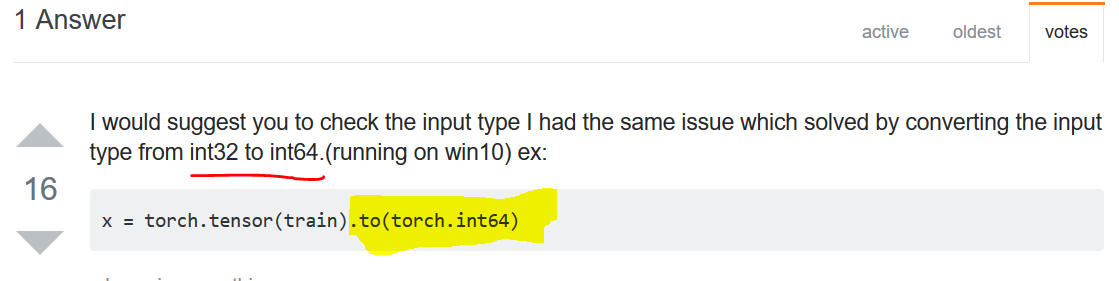

In [131]:
train_inputs

tensor([[    2,  9680, 27345,  ...,     0,     0,     0],
        [    2,  3544,     9,  ...,     0,     0,     0],
        [    2,  4931, 20335,  ...,     0,     0,     0],
        ...,
        [    2,  5693,     5,  ...,     0,     0,     0],
        [    2, 11685,     5,  ...,     0,     0,     0],
        [    2,    52, 29630,  ...,     0,     0,     0]])

In [132]:
  from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# バートを行う際、バッチサイズは32が推奨されている。
# 16 or 32.

batch_size = 32

# トレインデータを作る。（文字列、マスクを結合）
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# テストデータを作る。（文字列、マスクを結合）
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)


In [133]:
train_data[0]

(tensor([    2,  9680, 27345,  9594, 14084,   245, 27345,    23,   171,    14,
          1113,   707,   222,  9136, 28584, 29273,  4198,   523,     6,  9801,
         29977,   617,     1,  2048,     6, 16039,  1492, 28477,  2048,     6,
          2552,  9926,  9784,  2048,     6, 15921,  9432,     6, 10605,   732,
           224, 28922,     6,  8683,     5, 14561,     6, 10397,   245, 19015,
         30383,     6,   237, 31684,   245, 16039,  3695,     6,     1, 11776,
          3695,     6, 12878,     1,     6, 27196, 20241,     6,  6704, 28551,
         27196, 25745,     6, 11776, 26505,     3,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0]),
 tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [78]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    "bert-base-japanese-whole-word-masking", #日本語用のモデル！ 
    num_labels = 2, # 出力層の数！２値分類なら２。
                    # ９とかもいけます。  
    output_attentions = False,  
    output_hidden_states = False,
)

# Tell pytorch to run this model on the GPU.
model.cuda()

I0218 22:46:33.754431 13012 filelock.py:274] Lock 2136054906776 acquired on C:\Users\araik\.cache\torch\transformers\3c7c1cf64fda50b267a0e88bd23a88a7eaae4e8205f6ee4ceb472ef9e3274f29.7744b604e909ec6ffa1692fbdedb5b573f6348b1346d71aa16441b6956ef8f8a.lock
I0218 22:46:33.754431 13012 file_utils.py:413] https://s3.amazonaws.com/models.huggingface.co/bert/cl-tohoku/bert-base-japanese-whole-word-masking-config.json not found in cache or force_download set to True, downloading to C:\Users\araik\.cache\torch\transformers\tmpvfa77rbc


I0218 22:46:34.624534 13012 file_utils.py:423] storing https://s3.amazonaws.com/models.huggingface.co/bert/cl-tohoku/bert-base-japanese-whole-word-masking-config.json in cache at C:\Users\araik\.cache\torch\transformers\3c7c1cf64fda50b267a0e88bd23a88a7eaae4e8205f6ee4ceb472ef9e3274f29.7744b604e909ec6ffa1692fbdedb5b573f6348b1346d71aa16441b6956ef8f8a
I0218 22:46:34.634439 13012 file_utils.py:426] creating metadata file for C:\Users\araik\.cache\torch\transformers\3c7c1cf64fda50b267a0e88bd23a88a7eaae4e8205f6ee4ceb472ef9e3274f29.7744b604e909ec6ffa1692fbdedb5b573f6348b1346d71aa16441b6956ef8f8a
I0218 22:46:34.644508 13012 filelock.py:318] Lock 2136054906776 released on C:\Users\araik\.cache\torch\transformers\3c7c1cf64fda50b267a0e88bd23a88a7eaae4e8205f6ee4ceb472ef9e3274f29.7744b604e909ec6ffa1692fbdedb5b573f6348b1346d71aa16441b6956ef8f8a.lock
I0218 22:46:34.654581 13012 configuration_utils.py:254] loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/cl-tohoku/bert-bas

I0218 22:46:35.434367 13012 filelock.py:274] Lock 2136116500912 acquired on C:\Users\araik\.cache\torch\transformers\a2f827453709c7a74b48468cfea4ca3c7ebc260308a4cd52d5231dd02b73e315.6225a45d8bbedb200842a8cef5bc97d0631dad427835b9e916dfeb1c3b2a91e8.lock
I0218 22:46:35.444219 13012 file_utils.py:413] https://s3.amazonaws.com/models.huggingface.co/bert/cl-tohoku/bert-base-japanese-whole-word-masking-pytorch_model.bin not found in cache or force_download set to True, downloading to C:\Users\araik\.cache\torch\transformers\tmpquq181tt


I0218 22:49:05.881137 13012 file_utils.py:423] storing https://s3.amazonaws.com/models.huggingface.co/bert/cl-tohoku/bert-base-japanese-whole-word-masking-pytorch_model.bin in cache at C:\Users\araik\.cache\torch\transformers\a2f827453709c7a74b48468cfea4ca3c7ebc260308a4cd52d5231dd02b73e315.6225a45d8bbedb200842a8cef5bc97d0631dad427835b9e916dfeb1c3b2a91e8
I0218 22:49:05.911545 13012 file_utils.py:426] creating metadata file for C:\Users\araik\.cache\torch\transformers\a2f827453709c7a74b48468cfea4ca3c7ebc260308a4cd52d5231dd02b73e315.6225a45d8bbedb200842a8cef5bc97d0631dad427835b9e916dfeb1c3b2a91e8
I0218 22:49:05.927179 13012 filelock.py:318] Lock 2136116500912 released on C:\Users\araik\.cache\torch\transformers\a2f827453709c7a74b48468cfea4ca3c7ebc260308a4cd52d5231dd02b73e315.6225a45d8bbedb200842a8cef5bc97d0631dad427835b9e916dfeb1c3b2a91e8.lock
I0218 22:49:05.927179 13012 modeling_utils.py:458] loading weights file https://s3.amazonaws.com/models.huggingface.co/bert/cl-tohoku/bert-base-jap

I0218 22:49:09.190331 13012 modeling_utils.py:543] Weights of BertForSequenceClassification not initialized from pretrained model: ['classifier.weight', 'classifier.bias']
I0218 22:49:09.190331 13012 modeling_utils.py:549] Weights from pretrained model not used in BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']


AssertionError: 
Found no NVIDIA driver on your system. Please check that you
have an NVIDIA GPU and installed a driver from
http://www.nvidia.com/Download/index.aspx

In [47]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

# バートに関わるモデルのパラメタ設定。
## transformerのドキュメント⇒ https://huggingface.co/transformers/main_classes/optimizer_schedules.html

In [79]:
# damW=Adamの基本のアルゴリズムからWeight Decayに関する式を変更しました。
#自動調整された学習率の場合は、もともと期待していたWeight Decayの結果が得られず、精度が下がる事象が得られるようです。
#その事象を回避するために式を変更しています。
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

In [83]:
from transformers import get_linear_schedule_with_warmup

# エポック数２～４を推奨
epochs = 1

# トータルの学習回数
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, #さっき設定したAdamW
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

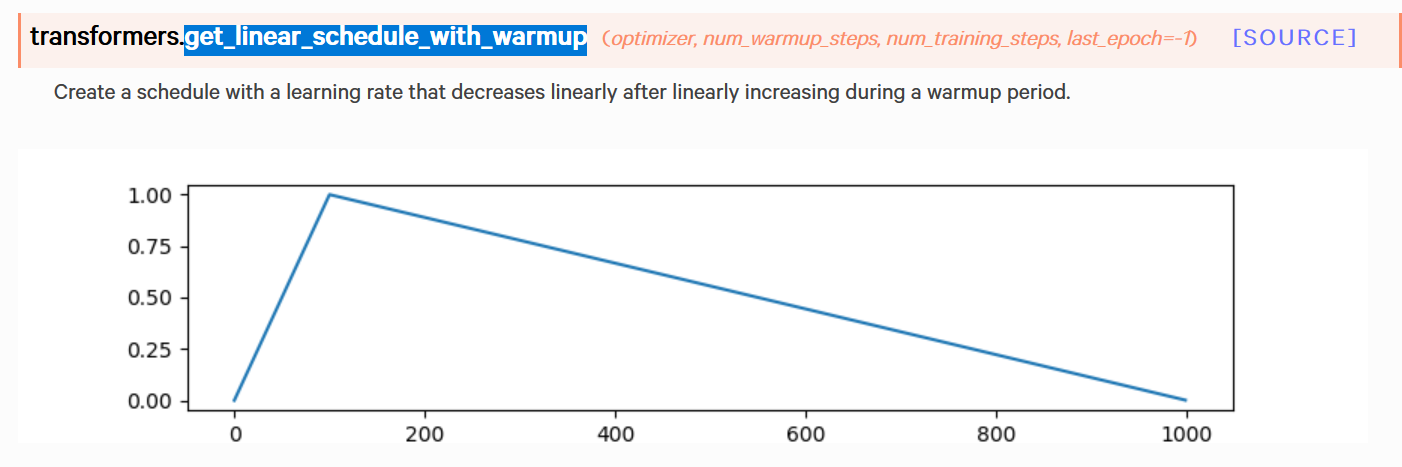

In [80]:
import numpy as np

# yとy＾の差分をとる関数
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [81]:
import time
import datetime

#時間測る関数
def format_time(elapsed):
    '''
    hh:mm:ssの文字列で返す！
    '''
    elapsed_rounded = int(round((elapsed)))    
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [93]:
len(b_input_ids)

32

In [134]:
import random

# このコードは `run_glue.py` を参考にしている。リンクは↓:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128


# セットシード！
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

#エポックごとに、差分を格納
loss_values = []

# エポック数だけ、ループします。
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    #スタートタイム
    t0 = time.time()

    #差分をリセット。次のエポックで差分を求める。
    total_loss = 0

    # model.train()を忘れないように
    # `dropout` と`batchnorm` layers を自動で追加してくれるようです。
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()
    
    # 学習します！！！！！！！！！！！！！！！！！！
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # １バッチごとに、モデルの重み（出力層の重み）を初期化しましょう！
        # パイトーチは自動でクリア処理をやらないみたいです！
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # ラベルを引数に入れることで、outputでは、損失値を返します。
        # ドキュメント↓↓ 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        outputs = model(b_input_ids, 
                    token_type_ids=None, 
                    attention_mask=b_input_mask, 
                    labels=b_labels)
        
        loss = outputs[0]

        #バッチごとの損失を求めるために、total_lossを求めます。
        total_loss += loss.item()

        # 勾配を求めるために、バッチ処理ごとにバックプロパゲーション！
        loss.backward()

        #バッチノーマリゼーションに当たる関数。標準正規分布で、勾配爆発を防ぐ。
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)


        #学習方法・学習率にしたがって、値をアップデート
        optimizer.step()
        scheduler.step()

    # 平均の損失
    avg_train_loss = total_loss / len(train_dataloader)            
    
    loss_values.append(avg_train_loss)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
        
    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    t0 = time.time()

    # during evaluation.
    model.eval()

    # Tracking variables 
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        
        # Telling the model not to compute or store gradients, saving memory and
        # speeding up validation
        with torch.no_grad():        

 
            # ラベルを与えていないので、このoutputsは、ロジット関数による予測値を返す。
            # ドキュメントは↓↓
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        
        logits = outputs[0]

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # Calculate the accuracy for this batch of test sentences.
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        
        # Accumulate the total accuracy.
        eval_accuracy += tmp_eval_accuracy

        # Track the number of batches
        nb_eval_steps += 1

    # Report the final accuracy for this validation run.
    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")


======== Epoch 1 / 1 ========
Training...

  Average training loss: 0.64
  Training epcoh took: 0:00:58

Running Validation...
  Accuracy: 0.60
  Validation took: 0:00:02

Training complete!


In [136]:
b_input_ids[0]

tensor([    2, 12743,    29,  8683,    12,   130,  2610,   124,     7,     8,
            3,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0])

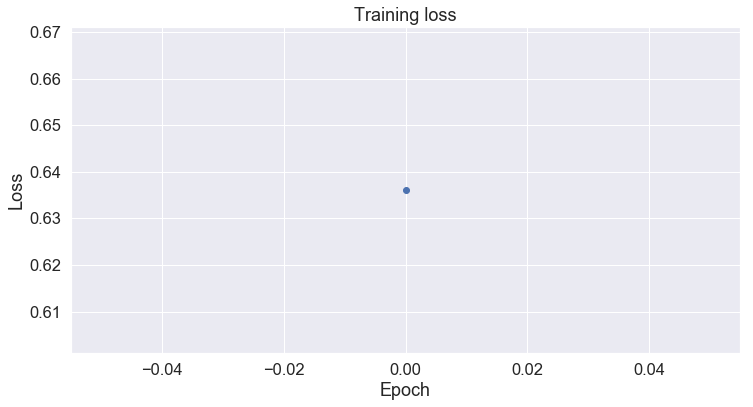

In [138]:
import matplotlib.pyplot as plt

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o')

# Label the plot.
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

In [151]:
import pandas as pd

# pandasリード。
df = pd.read_excel("out_of_GandS.xlsx")

# 文書数の出力.
print('Number of test sentences: {:,}\n'.format(df.shape[0]))

# 文とラベルに分離
sentences = df.sentence.values
labels = df.label.values

input_ids = []

# 文章⇒id
for sent in sentences:
    # `encode` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    encoded_sent = tokenizer.encode(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                   )
    
    input_ids.append(encoded_sent)

# パッド
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, 
                          dtype="long", truncating="post", padding="post")

# アテンションマスク
attention_masks = []

# パッド⇒アテンションマスク
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask) 

# テンソル化                                      ↓これいる。無いとエラー！！
prediction_inputs = torch.tensor(input_ids).to(torch.int64)
prediction_masks = torch.tensor(attention_masks).to(torch.int64)
prediction_labels = torch.tensor(labels).to(torch.int64)

# バッチサイズ 
batch_size = 32  

# 入力、マスク、予測値のマージ。
prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

Number of test sentences: 19



In [158]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(prediction_inputs)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]
  print(logits)

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 19 test sentences...
tensor([[ 0.1747, -0.9989],
        [ 0.1724, -0.9445],
        [ 0.0357, -0.4925],
        [ 0.1514, -0.9412],
        [-0.1146, -0.9125],
        [-0.1362, -0.4215],
        [ 0.1705, -1.0848],
        [-0.1230, -0.9331],
        [-0.1244, -0.6734],
        [ 0.1333, -0.8378],
        [ 0.2347, -0.9541],
        [ 0.1175, -0.8373],
        [-0.0171, -0.5176],
        [ 0.0552, -0.6940],
        [ 0.0748, -0.7695],
        [ 0.0102, -0.6189],
        [ 0.1076, -0.4506],
        [ 0.0610, -0.4414],
        [ 0.0756, -0.3639]])
    DONE.


In [160]:
print('Positive samples: %d of %d (%.2f%%)' % (df.label.sum(), len(df.label), (df.label.sum() / len(df.label) * 100.0)))

Positive samples: 11 of 19 (57.89%)


In [154]:
from sklearn.metrics import matthews_corrcoef

matthews_set = []

# Evaluate each test batch using Matthew's correlation coefficient
print('Calculating Matthews Corr. Coef. for each batch...')

# For each input batch...
for i in range(len(true_labels)):
  
  # ２つの列の内。大きい方のインデックスを返す。
  pred_labels_i = np.argmax(predictions[i], axis=1).flatten()
  
  # Calculate and store the coef for this batch.  
  matthews = matthews_corrcoef(true_labels[i], pred_labels_i)                
  matthews_set.append(matthews)

Calculating Matthews Corr. Coef. for each batch...


In [162]:
np.argmax(predictions[i], axis=1).flatten()

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
      dtype=int64)

In [155]:
pred_labels_i

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
      dtype=int64)

In [156]:
true_labels

[array([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       dtype=int64)]

In [149]:
#マシューズ相関係数。－１～１。
matthews_set

[0.0]

In [0]:
#全て０と予測したが、１のラベルを持つ文章では、１列目が小さく、２列目が大きくなっている。
#プログラムとしては問題ないが、データの質・量の影響を受けて、あまり良くないモデルが出来ていると考えられる。

# And More・・・。

Here is the current list of classes provided for fine-tuning:

    BertModel
    BertForPreTraining←転移学習元のデータ
    BertForMaskedLM←マスク化した単語を予測
    BertForNextSentencePrediction←次にくる文章を予測
    BertForSequenceClassification - 今回使った関数（２以外もできる９とか）.
    BertForTokenClassification←
    BertForQuestionAnswering←質問に対する答えを予測

The documentation for these can be found under here⇒https://huggingface.co/transformers/v2.2.0/model_doc/bert.html

## ★GLUEについて知るhttps://lib-arts.hatenablog.com/entry/dataset_ml4  
https://gluebenchmark.com/